# Implementação - Modelos de Volatilidade Estocástica

**Aluno:** Franklin Oliveira

-----

Nesse notebook, vamos apresentar a implementação de modelos de volatilidade estocástica (SV). Para isso, vamos adotar a formulação de modelos de espaço-estado, onde estamos interessados em estimar a volatilidade (estado - $h_t$), que não é diretamente observável, para uma série $y_t$ realizada.  

Vamos começar com o modelo mais simples...

-----

## Modelo Canônico

<center> $ y_t = \beta \exp \left\{\frac{h_t}{2} \right\} u_t~~~$ <font color='blue'>(output - medições observadas) </font></center>

<center> $ h_t = \mu + \phi(h_{t-1} - \mu) + \sigma \eta_t  ~~~$ <font color='green'>(mudança de estado) </font></center>

<center> $h_1 \sim \mathcal{N} \left(\mu, \frac{\sigma^2}{1 - \phi^2} \right)$ </center>

Onde $h_t$ é a log-volatilidade não observada de $y_t$, e $u_t$ e $\eta_t$ são ruídos brancos gaussianos, i.e., 

$$u_t \sim \mathcal{N}(\mu_u, \sigma_u^2)~~\text{e}~~\eta_t \sim \mathcal{N}(\mu_{\eta}, \sigma_{\eta}^2)$$


Para exemplificar, vamos usar esse modelo para estimar a volatilidade do índice Ibovespa.



In [61]:
%matplotlib inline

import numpy as np
import numpy.random as rng
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import multivariate_normal, invgamma
from scipy.stats import norm, uniform
from statsmodels.tsa.statespace.tools import is_invertible
from statsmodels.graphics.tsaplots import plot_acf
from IPython.display import clear_output

sns.set()

Vamos começar importando a série do Ibovespa...

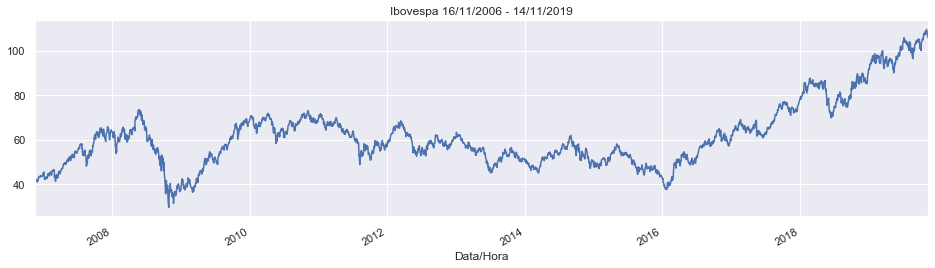

In [62]:
df = pd.read_csv('ibov.csv', sep=';', encoding='utf-8-sig', index_col=0)

# data para datetime
df['Data/Hora'] = pd.to_datetime(df['Data/Hora'], format='%d/%m/%Y')

df.set_index('Data/Hora')['Cotação'].plot(kind='line', figsize=(16,4), 
                                          title='Ibovespa 16/11/2006 - 14/11/2019')

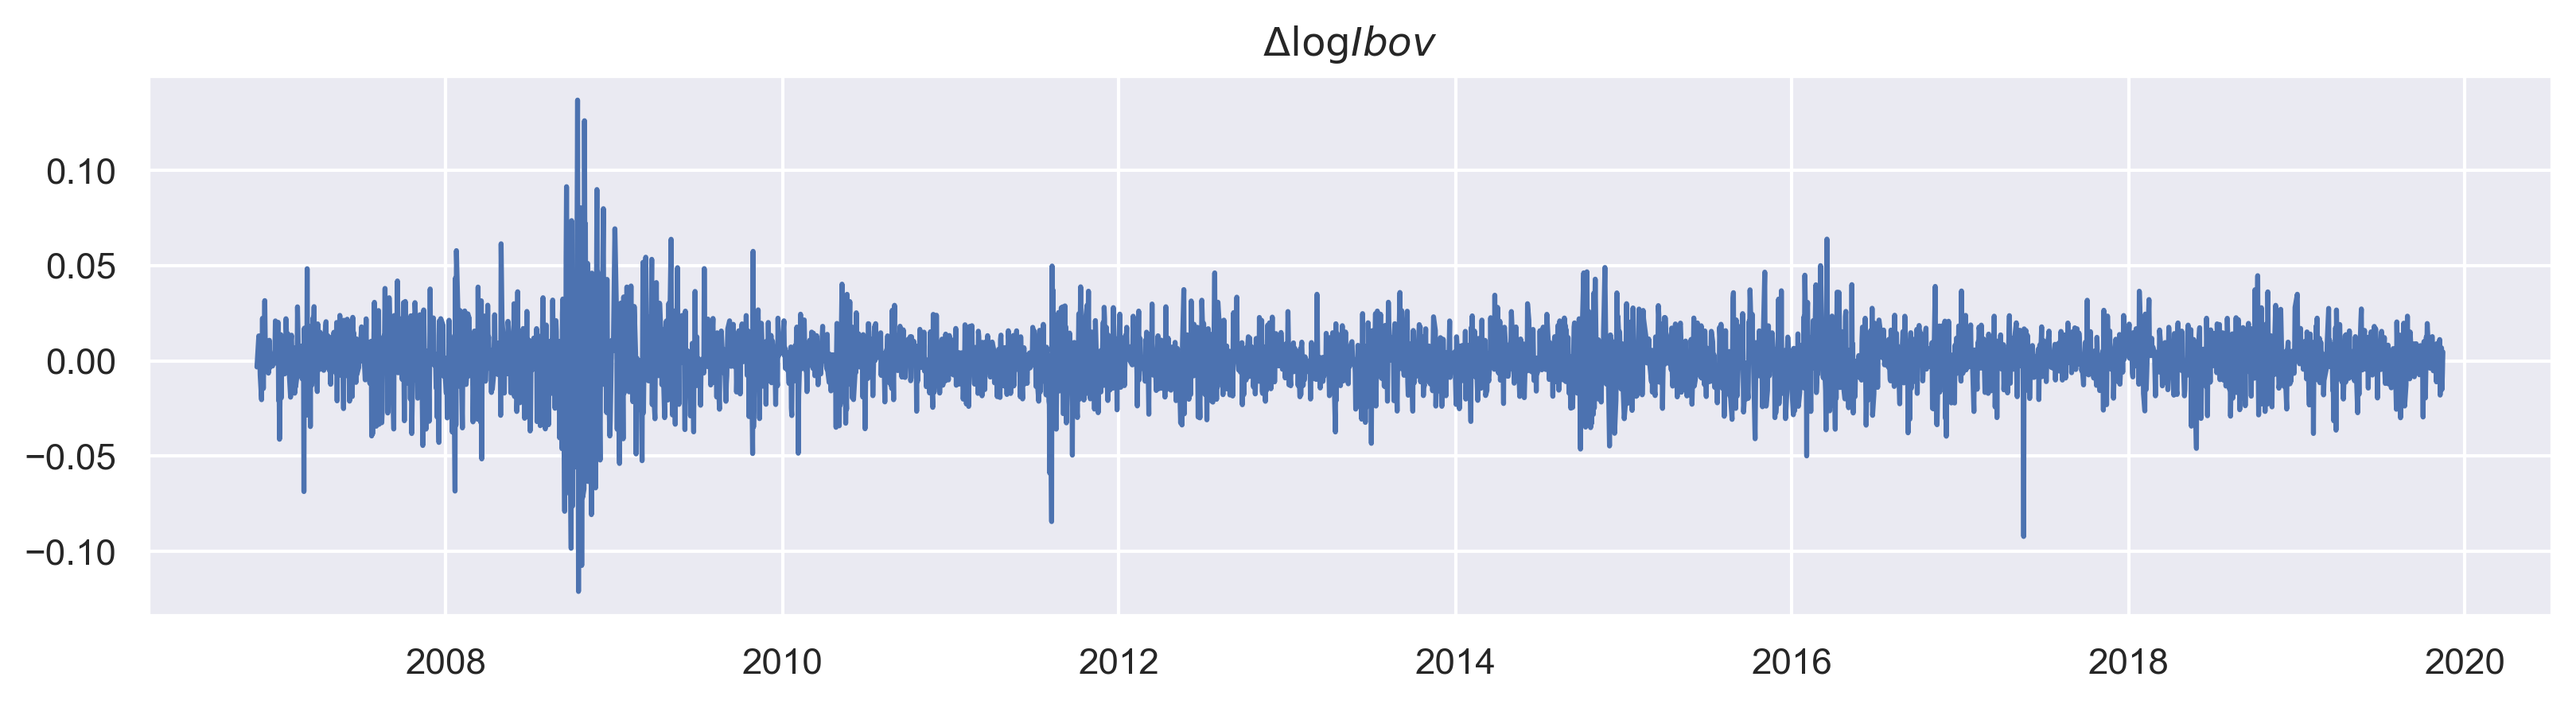

In [63]:
ibov = df.set_index('Data/Hora')['Cotação'].sort_index(ascending=True)
log_ibov = np.log(ibov).diff()[1:] 

# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(log_ibov, label=r'$\Delta \log Ibov$')
ax.set_title(r'$\Delta \log Ibov$')
ax.yaxis.grid(b=True);

Tomaremos o nosso $y$ na forma de log-retorno corrigido pela média, i.e.,

$$
y_t = 100 \left\{ \left( \log IBOV_t - \log IBOV_{t-1} \right) - \frac{1}{n} \sum_{i=1}^n \left( \log IBOV_i - \log IBOV_{i-1} \right) \right\}
$$

In [64]:
# y = log-retorno corrigido pela média
y = 100*(log_ibov - np.cumsum(log_ibov)/np.array(range(1,len(ibov))))[:1000]

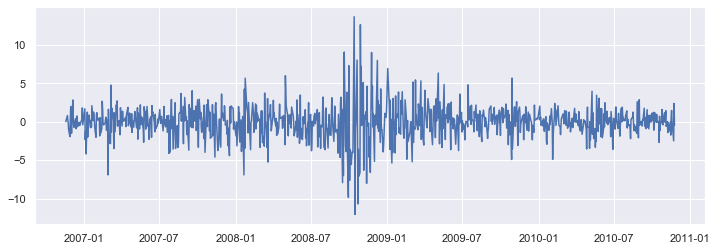

In [65]:
plt.figure(figsize=(12,4))
plt.plot(y)

<br>

## Algoritmo base: Gibbs-Sampler

No paper original (Kim, Shephard e Chib - 1998), foram executadas 1.000.000 iterações, com um *burn-in* de 50.000 observações.

In [66]:
# Passo 1: inicializando objetos
T = len(y)  # Nº de obs de Y
N = 1001  # tamanho das amostras ("batch size")

h = np.zeros(N*T).reshape(N,T)
phi = np.zeros(N).reshape(N)
s2_n = np.zeros(N).reshape(N)
mu = np.zeros(N).reshape(N)
beta = np.zeros(N).reshape(N)

# valores iniciais
phi[0] = 0.95
s2_n[0] = 0.02
# mu[0] = np.random.normal(loc=0, scale=10, size=1)  # N(0,10)
mu[0] = 0
beta[0] = np.exp(mu[0]/2)
sigma_r = 5
S_sigma = 0.01 * sigma_r

# h[:,0] = np.random.normal(loc=mu[0], scale = np.sqrt(s2_n[0]/(1-phi[0]**2)), size=N)

In [60]:
### Gibbs sampler
for i in tqdm(range(N-1)):    
    ### Passo 2: para cada t, executo até h_t ser aceito (acc = False)
    for t in range(1,T-1):
        acc = True
        while acc:
            # amostrando ht de p(ht|h\t, y, phi, mu, s2_n)
            h_star = mu[i] + (phi[i] * ((h[i][t-1] - mu[i]) + (h[i][t+1] - mu[i])))/(1+phi[i]**2)
            v = s2_n[i]/(1+phi[i]**2)
            m = h_star + (v/2) * ((y[t]**2)*np.exp(-h_star)-1)
            h_prop = np.random.normal(loc=m, scale=np.sqrt(v), size=1)[0]  # h proposto
            
            # prob de aceitação
            f_star = -(1/2)*h_prop - (y[t]**2)/2 * np.exp(-h_prop)
            g_star = -(1/2)*h_prop - (y[t]**2)/2 * (np.exp(-h_star)*(1+h_star) - h_prop * np.exp(-h_star))
            if np.random.uniform() < np.exp(f_star - g_star):  # Aceito / Rejeito h_prop
                h[i][t] = h_prop # aceita h[t] ### OBS: troquei h[i][t] por h[i][t+1]
                acc = False
                
    
    print('Sai do h',acc)

    ### Passo 3:  amostrando s2_n de p(s2_n|h,y,mu,phi)
    a = (N + sigma_r)
    # calcula soma_t=1^n (h_t+1 - mu)-phi(h_t-mu)^2
    soma = []
    for t in range(1,T-1):
        soma.append(((h[i][t+1] - mu[i])-phi[i]*(h[i][t] - mu[i]))**2) # termos do somatório   
    b = S_sigma + (h[i][0] - mu[i])**2 * (1-phi[i]**2) + np.sum(soma)
    s2_n[i+1] = 1/np.random.gamma(shape=a/2, scale= b/2, size=1)
    
    ### Passo 4: amostrando phi de p(phi | h,y,mu,s2_n)
    soma_phi = []
    soma_v = []
    for t in range(T-1):
        soma_phi.append((h[i][t+1] - mu[i])*(h[i][t] - mu[i]))
        soma_v.append((h[i][t] - mu[i])**2)
    # parâmetros da condicional
    phi_hat = np.sum(soma_phi)/np.sum(soma_v)               # média
    v_hat = s2_n[i+1]/np.sum(soma_v)                        # variância
    phi_prop = np.random.normal(phi_hat, np.sqrt(v_hat), size=1)[0]  # phi proposto

    # probabilidade de aceitação: e^{g_prop - g}
    priori_phi_prop = (((1+phi_prop)/2)**19) * ((1-phi_prop)/2)**0.5
    g_prop = np.log(priori_phi_prop) - (((h[i][0] - mu[i])**2)*(1-phi_prop**2))/(2*s2_n[i+1]) + 1/2*np.log(1-phi_prop**2)

    priori_phi = (((1+phi[i])/2)**19) * ((1-phi[i])/2)**0.5
    g = np.log(priori_phi) - ((h[i][0] - mu[i])**2*(1-phi[i]**2))/2*s2_n[i] + 1/2*np.log(1-phi[i]**2)
    
    if np.random.uniform() < np.exp(g_prop - g):
        phi[i+1] = phi_prop
    else:
        phi[i+1] = phi[i]
    
    ### Passo 5: amostrando mu de p(mu|h,y,phi,s2_n)
    s = s2_n[i+1]/((N-1)*(1-phi[i+1])**2 + (1-phi[i+1]**2))
    soma = []
    for t in range(T-1):
        soma.append(h[i][t+1] - phi[i+1]*h[i][t])
        
    m = s * ((1-phi[i+1]**2)*h[i][0]/s2_n[i+1] + ((1-phi[i+1])/s2_n[i+1] * np.sum(soma)))
    mu[i+1] = np.random.normal(loc=m, scale=np.sqrt(s), size=1)[0]
    beta[i+1] = np.exp(mu[i+1]/2)
    print(i, '\b')













  0%|          | 0/1000 [00:04<?, ?it/s]


KeyboardInterrupt: 

**Agora, vamos plotar a série dos log-retornos do Ibovespa e a volatilidade "estimada".**

In [ ]:
# salvando resultados em pickle
# pd.DataFrame(h).to_pickle('algo_base_h.pickle')
# pd.DataFrame([phi, s2_n, mu, beta], index=['phi', 's2_n', 'mu', 'beta']).transpose().to_pickle('algo_base_params.pickle')

In [ ]:
# salvando resultados em csv
# pd.DataFrame(h).to_csv('algo_base_h.csv')
# pd.DataFrame([phi, s2_n, mu, beta], index=['phi', 's2_n', 'mu', 'beta']).transpose().to_csv('algo_base_params.csv')

In [ ]:
# OBS: se der tempo, transformar para y em nível e fazer mesmo gráfico com a volatilidade
plt.figure(figsize=(12,6))
plt.plot(y.index,y);
plt.plot(y.index,h.T, 'ob', alpha=0.2, color='firebrick');

**Cadeias de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.lineplot(x=list(range(N-100)),y=phi[100:], ax = ax[0])
sns.lineplot(x=list(range(N-100)),y=s2_n[100:], ax = ax[1])
sns.lineplot(x=list(range(N-100)),y=beta[100:], ax = ax[2])

ax[0].set_title(r'$\phi|y$ against iteration');
ax[1].set_title(r'$\sigma^2_{\eta}|y$ against iteration');
ax[2].set_title(r'$\beta|y$ against iteration');

**Distribuições de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

In [1]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.distplot(phi, ax = ax[0], norm_hist= True)
sns.distplot(s2_n, ax = ax[1], norm_hist= True)
sns.distplot(beta, ax = ax[2], norm_hist= True)

ax[0].set_title(r'Distribution of $\phi|y$')
ax[1].set_title(r'Distribution of $\sigma^2_{\eta}|y$')
ax[2].set_title(r'Distribution of $\beta|y$')

NameError: name 'plt' is not defined

**Autocorrelação de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_acf(phi, ax = ax[0], title=r'$\phi | y$');
plot_acf(s2_n, ax = ax[1], title=r'$\sigma^2_{\eta} | y$');

plot_acf(beta, ax = ax[2], title=r'$\beta | y$');

**Métricas de performance**

In [ ]:
np.mean(phi)

In [ ]:
### simulation inefficiency factors
# numerical standard error of the sample mean
# 1 + 2Bm/(Bm-1) = np.sum(1/Bm)


In [ ]:
# variância e covariância
pd.DataFrame([phi, s2_n, beta], index=['phi', 's2', 'beta']).transpose().cov()

<br>

## Algoritmo 1: Gibbs-Sampler modificado

Há melhores formas de aproximar a distribuição do termo $\log \varepsilon_t^2$, que não por uma gaussiana. A proposta dos autores com esse algoritmo é aproximar essa distribuição (complicada) por uma mistura de gaussianas, mais precisamente, 7 gaussianas. 

### Forma analítica do modelo

Primeiramente, defina: 
$$
y^*_t = log(y_t^2 + c),~~\text{onde}~c=0.001
$$

Essa transformação em $y_t$ tem como base Fuller (1996) para "robustificar" o estimador QML do modelo de SV para valores muito pequenos de $y_t^2$. Não obstante, note que $y_t$ e $y_t^*$ têm a mesma informação. 

Assim, temos as seguintes equações de dinâmica do modelo:

<br>

<center> $ y^*_t = h_t + z_t $ <font color='blue'>(output - medições observadas) </font></center>

<center> $ h_t = \mu + \phi(h_{t-1} - \mu) + \sigma \eta_t  ~~~$ <font color='green'>(mudança de estado) </font></center>
<center> $f(z_t) = \sum_{i=1}^K q_i f_N(z_t \mid m_t - 1.2704, v_i^2)  ~~~$ </center>

<br>

A última equação equivale a 

$$
z_t \mid s_t = 1 \sim \mathcal{N}(m_i - 1.2704, v_i^2),\\
P(s_t = i) = q_i
$$


<br>

<font color='red'>**OBS:** Escrever forma analítica do modelo e o passo a passo do algoritmo, assim como as condicionais 

A única diferença desse algoritmo em relação ao anterior é a amostragem de $h_t$ e de $s_i$, que é a variável que "escolhe" a gaussiana para amostrar.
</font>

In [ ]:
c = 0.01
y_star = np.log(y**2+c)  # definindo o y*

In [ ]:
# Passo 1: inicializando objetos
T = len(y_star)  # Nº de obs de Y
N = 1000    # tamanho das amostras ("batch size")

h = np.zeros(N*T).reshape(N,T)  # ANTES ERA UMA MATRIZ np.zeros(N*T).reshape(N,T)
phi = np.zeros(N).reshape(N)
s2_n = np.zeros(N).reshape(N)
mu = np.zeros(N).reshape(N)
beta = np.zeros(N).reshape(N)

### Mistura de normais
q = np.array([0.00730, 0.10556, 0.00002, 0.04395, 0.34001, 0.24566, 0.25750])       # probabilidades p(s=i)
mt = np.array([-10.12999, -3.97281, -8.56686, 2.77786, 0.61942, 1.79518, -1.08819]) # médias
vt = np.array([5.79596, 2.61369, 5.17950, 0.16735, 0.64009, 0.34023, 1.26261])      # variâncias
s_t = np.zeros(N*T, dtype=int).reshape(N,T)  # vetor para armazenar o s de cada iteração
q_t = np.zeros(N*7).reshape(T,7)         # vetor para armazenar p(s|y*,h_t)

q_t[0] = q

# offset mixture selector
s = np.random.choice(np.array(range(7), dtype=int), size=1, p=q)[0]  # define a amostragem da mistura (de qual gaussiana amostrar)
s_t[0] = s

# valores iniciais
phi[0] = 0.95
s2_n[0] = 0.02
mu[0] = 0
beta[0] = np.exp(mu[0]/2)
sigma_r = 5
S_sigma = 0.01 * sigma_r

atualiza h, atualiza TODO o vetor de probabilidades, depois amostra s_t.

In [ ]:
### Gibbs sampler
for i in tqdm(range(N-1)): 
    q_t[0] = q
    for t in range(T-1):
        z = np.random.normal(loc = mt[s_t[i][t]], scale=np.sqrt(vt[s_t[i][t]]),size=1)[0]
        ### Passo 2: para cada t, executo até h_t ser aceito (acc = False)
        h[i][t] = y_star[i] - z

        ### Passo 3: amostrando s de p(s_t = i|y*, h)
        for j in range(7):
            q_t[t+1][j] = q_t[t][j] * stats.norm.pdf(y_star[t],loc=h[i][t]+mt[j]-1.2703, 
                                                       scale=np.sqrt(vt[j]))
        q_t[t+1] = q_t[t+1]/np.sum(q_t[t+1])
        s_t[t+1] = np.random.choice(np.array(range(7), dtype=int), size=1, p=q_t[t+1])[0]

    ### Passo 4:  amostrando s2_n de p(s2_n|h,y,mu,phi)
    a = (N + sigma_r)
    # calcula soma_t=1^n (h_t+1 - mu)-phi(h_t-mu)^2
    soma = []
    for t in range(T-1):
        soma.append(((h[i][t+1] - mu[i])-phi[i]*(h[i][t] - mu[i]))**2) # termos do somatório    
    b = S_sigma + (h[i][0] - mu[i])**2 * (1-phi[i]**2) + np.sum(soma)
    s2_n[i+1] = 1/np.random.gamma(shape=a/2, scale= b/2, size=1)
    
    ### Passo 4: amostrando phi de p(phi | h,y,mu,s2_n)
    soma_phi = []
    soma_v = []
    for t in range(T-1):
        soma_phi.append((h[i][t+1] - mu[i])*(h[i][t] - mu[i]))
        soma_v.append((h[i][t] - mu[i])**2)
    # parâmetros da condicional
    phi_hat = np.sum(soma_phi)/np.sum(soma_v)               # média
    v_hat = s2_n[i+1]/np.sum(soma_v)                        # variância
    phi_prop = np.random.normal(phi_hat, np.sqrt(v_hat), size=1)[0]  # phi proposto

    # probabilidade de aceitação: e^{g_prop - g}
    priori_phi_prop = (((1+phi_prop)/2)**19) * ((1-phi_prop)/2)**0.5
    g_prop = np.log(priori_phi_prop) - ((h[i][0] - mu[i])**2*(1-phi_prop**2))/2*s2_n[i+1] + 1/2*np.log(1-phi_prop**2)

    priori_phi = (((1+phi[i])/2)**19) * ((1-phi[i])/2)**0.5
    g = np.log(priori_phi) - ((h[i][0] - mu[i])**2*(1-phi[i]**2))/2*s2_n[i] + 1/2*np.log(1-phi[i]**2)
    
    if np.random.uniform() < np.exp(g_prop - g):
        phi[i+1] = phi_prop
    else:
        phi[i+1] = phi[i]
    
    ### Passo 5: amostrando mu de p(mu|h,y,phi,s2_n)
    s = s2_n[i+1]/((N-1)*(1-phi[i+1])**2 + (1-phi[i+1]**2))
    soma = []
    for t in range(T-1):
        soma.append(h[i][t+1] - phi[i+1]*h[i][t])
        
    m = s * ((1-phi[i+1]**2)*h[i][0]/s2_n[i+1] + ((1-phi[i+1])/s2_n[i+1] * np.sum(soma)))
    mu[i+1] = np.random.normal(loc=m, scale=np.sqrt(s), size=1)[0]
    beta[i+1] = np.exp(mu[i+1]/2)

In [ ]:
# OBS: se der tempo, transformar para y em nível e fazer mesmo gráfico com a volatilidade
plt.figure(figsize=(12,6))
plt.plot(y_star.index,y_star);
plt.plot(y_star.index,h, 'ob', alpha=0.2, color='firebrick');

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.lineplot(x=list(range(N-100)),y=phi[100:], ax = ax[0])
sns.lineplot(x=list(range(N-100)),y=s2_n[100:], ax = ax[1])
sns.lineplot(x=list(range(N-100)),y=beta[100:], ax = ax[2])

ax[0].set_title(r'$\phi|y$ against iteration');
ax[1].set_title(r'$\sigma^2_{\eta}|y$ against iteration');
ax[2].set_title(r'$\beta|y$ against iteration');